In [19]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from scipy import stats 



Dataset can be domwloaded here:https://archive.ics.uci.edu/dataset/222/bank+marketing

In [20]:
# Fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# Data (as pandas dataframe)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Convert X to dataframe
df = pd.DataFrame(X, columns=bank_marketing.data.feature_names)

# Summary statistics of the dataset
summary_stats = df.describe()
print("Summary Statistics:")
print(summary_stats)


Summary Statistics:
                age        balance   day_of_week      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%    

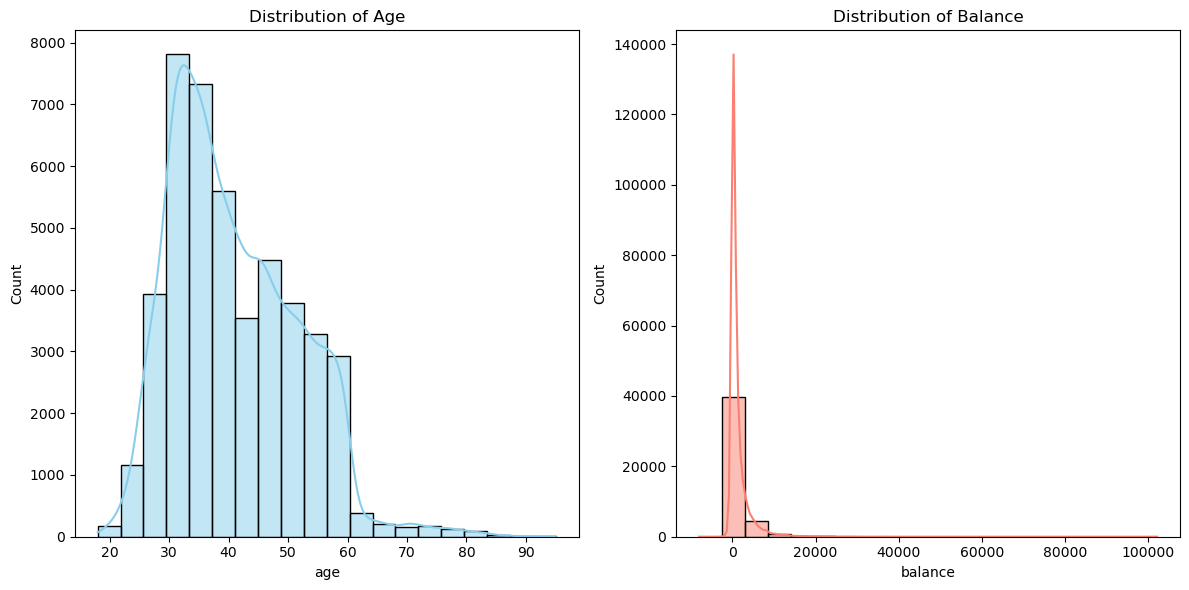

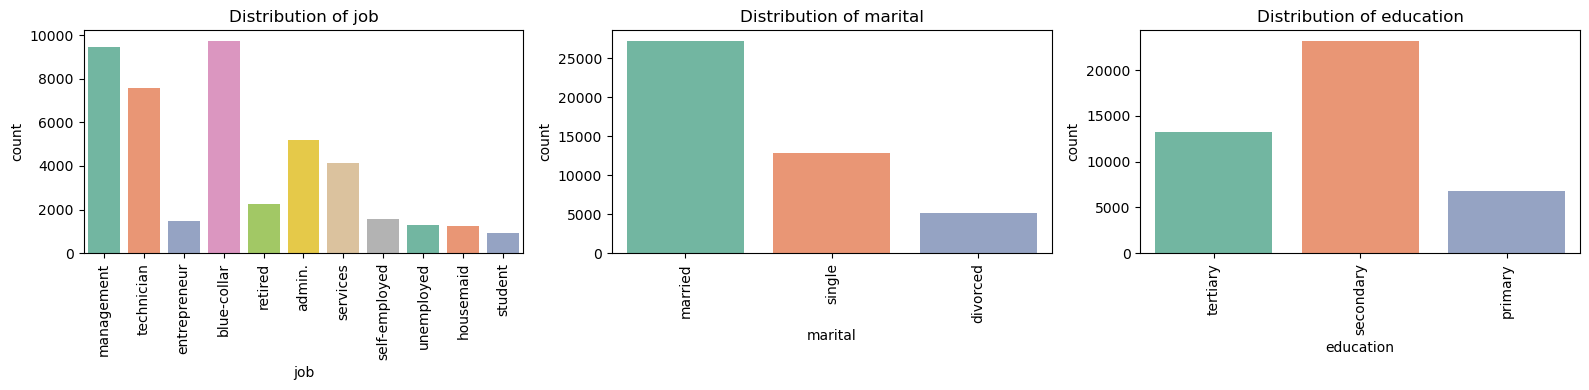

In [21]:
# Distribution of age and balance
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(df['balance'], bins=20, kde=True, color='salmon')
plt.title('Distribution of Balance')

plt.tight_layout()
plt.show()

# Visualization
plt.figure(figsize=(16, 4))

categorical_vars = ['job', 'marital', 'education']

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=var, palette='Set2')
    plt.title(f'Distribution of {var}')
    plt.xticks(rotation=90, ha='center')

plt.tight_layout()
plt.show()


In [22]:
df['y'] = y  

# Convert non-numeric columns to numeric
non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
df[non_numeric_cols] = df[non_numeric_cols].apply(lambda x: pd.factorize(x)[0])

# Handling missing values for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
imputer_numeric = SimpleImputer(strategy='mean')
df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])

# Encoding categorical variables
categorical_cols = df.select_dtypes(exclude=[np.number]).columns
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])
encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))
df_encoded = pd.concat([df.drop(columns=categorical_cols), encoded_cols_df], axis=1)

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_encoded.drop(columns=['y']))
df_scaled = pd.DataFrame(scaled_features, columns=df_encoded.drop(columns=['y']).columns)
df_scaled['y'] = df_encoded['y']  # Add target variable back to the dataframe

# Display the preprocessed dataframe
print("Preprocessed Dataframe:")
print(df_scaled.head())




Preprocessed Dataframe:
        age       job   marital  education  default   balance   housing  \
0  1.606965 -1.157660 -0.740666  -1.036362 -0.13549  0.256419 -0.893915   
1  0.288529 -0.787331  0.702458   0.300556 -0.13549 -0.437895 -0.893915   
2 -0.747384 -0.417002 -0.740666   0.300556 -0.13549 -0.446762 -0.893915   
3  0.571051 -0.046673 -0.740666  -2.373280 -0.13549  0.047205 -0.893915   
4 -0.747384 -1.527989  0.702458  -2.373280 -0.13549 -0.447091  1.118674   

       loan   contact  day_of_week     month  duration  campaign     pdays  \
0 -0.436803 -1.412108    -1.298476 -0.924841  0.011016 -0.569351 -0.411453   
1 -0.436803 -1.412108    -1.298476 -0.924841 -0.416127 -0.569351 -0.411453   
2  2.289359 -1.412108    -1.298476 -0.924841 -0.707361 -0.569351 -0.411453   
3 -0.436803 -1.412108    -1.298476 -0.924841 -0.645231 -0.569351 -0.411453   
4 -0.436803 -1.412108    -1.298476 -0.924841 -0.233620 -0.569351 -0.411453   

   previous  poutcome    y  
0  -0.25194 -0.415287  0.0 

/Users/lidiiakliuchna/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


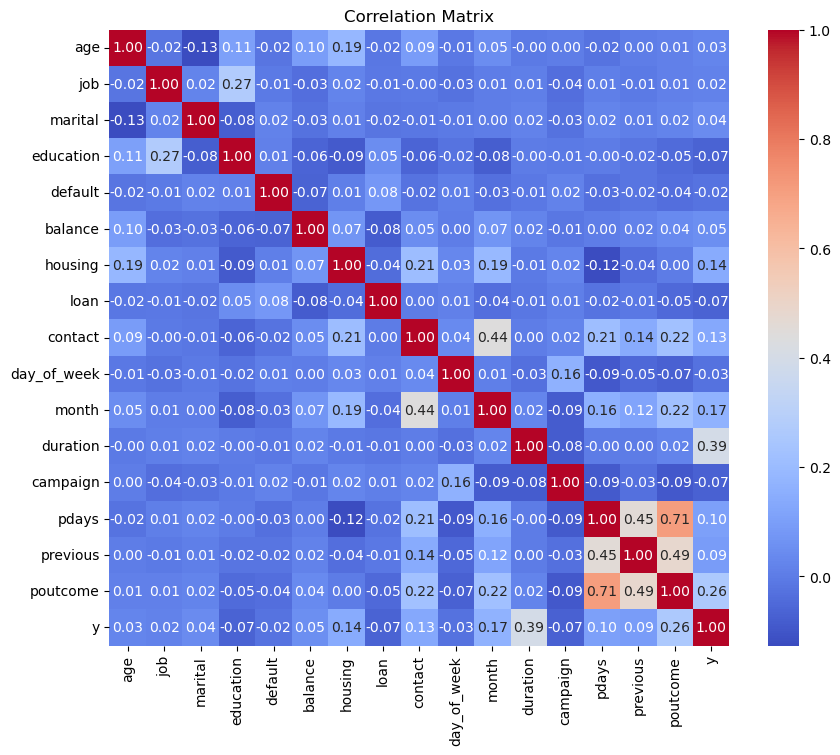

In [23]:
# Correlation analysis between numeric variables
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


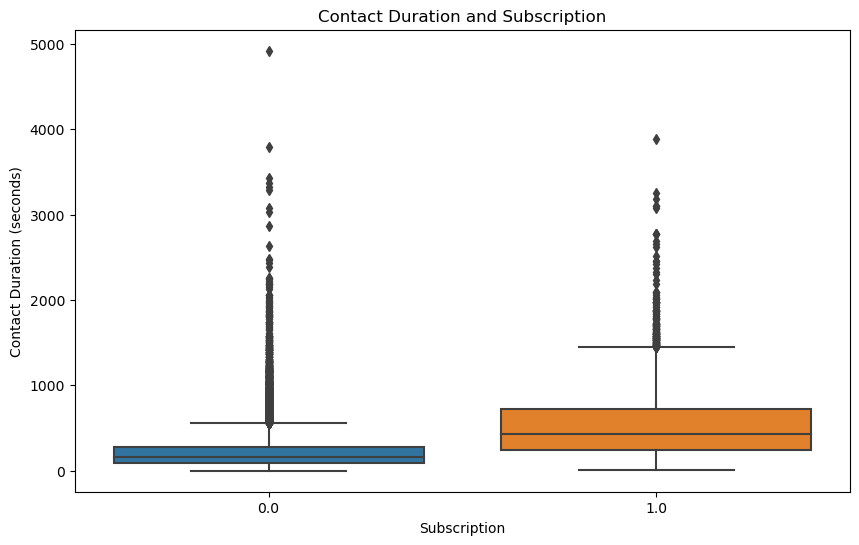

In [24]:
# Analysis of contact duration and its relation to subscription
plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Contact Duration and Subscription')
plt.xlabel('Subscription')
plt.ylabel('Contact Duration (seconds)')
plt.show()

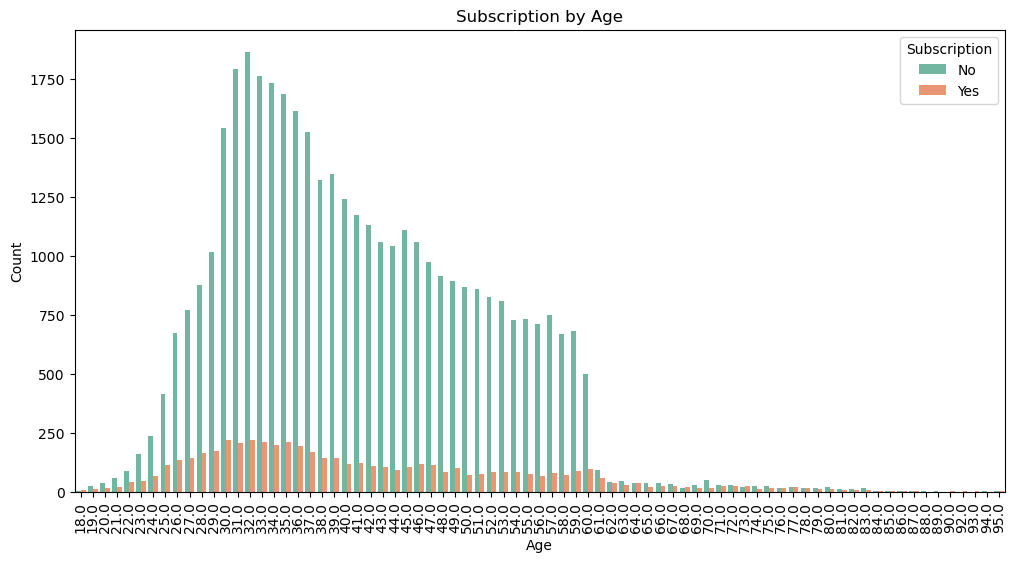

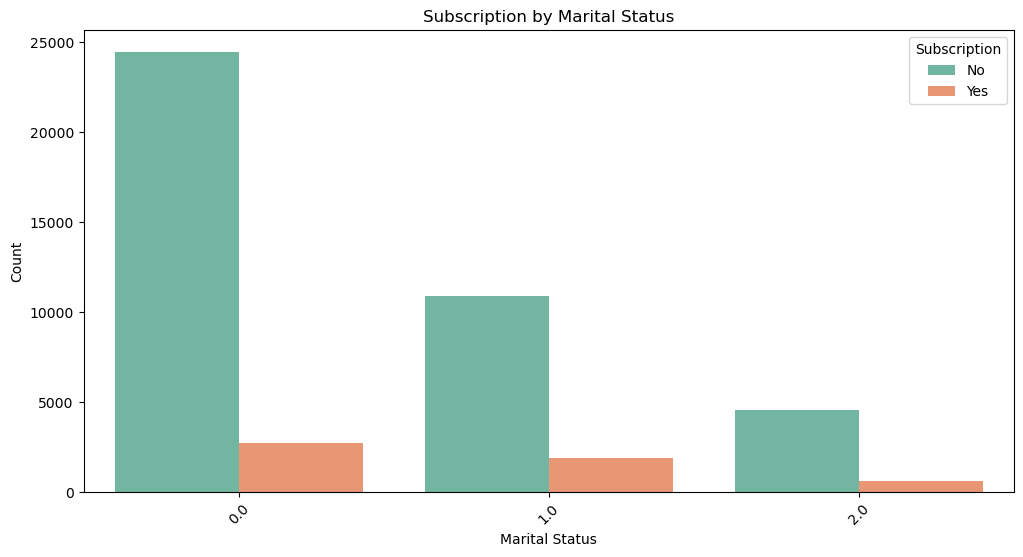

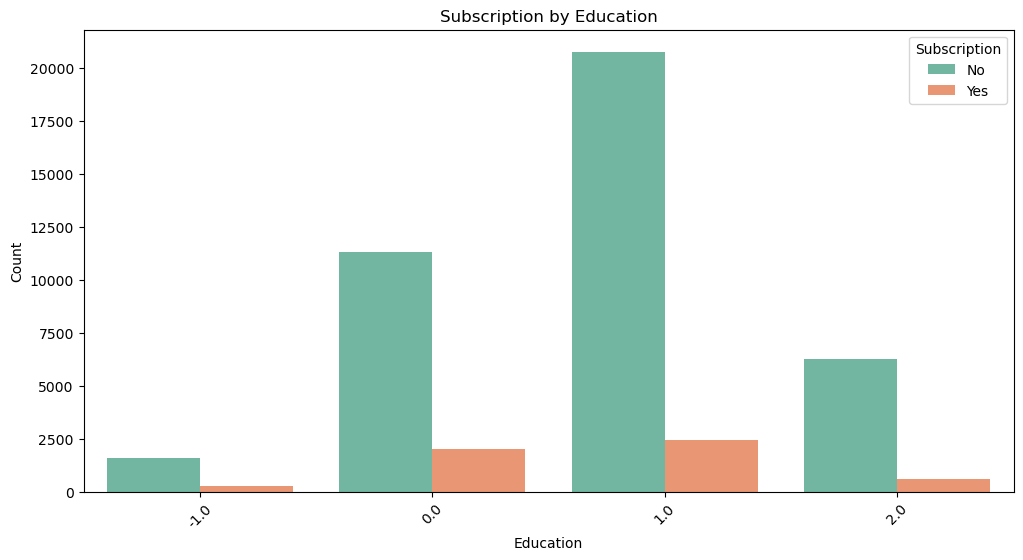

In [25]:
# Identification of trends or patterns in customer behavior
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='age', hue='y', palette='Set2')
plt.title('Subscription by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Subscription', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='marital', hue='y', palette='Set2')
plt.title('Subscription by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Subscription', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='education', hue='y', palette='Set2')
plt.title('Subscription by Education')
plt.xlabel('Education')
plt.ylabel('Count')
plt.legend(title='Subscription', loc='upper right', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

In [26]:
spark = SparkSession.builder \
    .appName("Bank Marketing Analysis") \
    .getOrCreate()

spark_df = spark.createDataFrame(df_scaled)

# Chi-square test 
for col_name in categorical_cols:
    chi_sq_result = spark_df.stat.crosstab('y', col_name).toPandas()
    print("Chi-square test for", col_name)
    print(chi_sq_result)

for col_name in numeric_cols:
    selected_data = spark_df.select('y', col_name)

# Correlation analysis using Pearson correlation coefficient
feature_columns = [col_name for col_name in spark_df.columns if col_name != 'y']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(spark_df).select("features")
correlation_matrix = Correlation.corr(df_assembled, "features").head()
print("Pearson correlation matrix:")
print(str(correlation_matrix[0]))



Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00, -1.93376320e-02, -1.26351157e-01,
               1.06806594e-01, -1.78793036e-02,  9.77827394e-02,
               1.85513082e-01, -1.56552727e-02,  9.25769237e-02,
              -9.12004563e-03,  4.93917226e-02, -4.64842847e-03,
               4.76031176e-03, -2.37580141e-02,  1.28831920e-03,
               1.22377857e-02],
             [-1.93376320e-02,  1.00000000e+00,  2.18397884e-02,
               2.72128688e-01, -5.15398073e-03, -3.41091717e-02,
               2.21755628e-02, -9.06546059e-03, -4.95155731e-03,
              -2.65436263e-02,  5.09484605e-03,  8.97790014e-03,
              -3.53964020e-02,  9.47149562e-03, -6.69852226e-03,
               1.19997593e-02],
             [-1.26351157e-01,  2.18397884e-02,  1.00000000e+00,
              -8.07585990e-02,  1.84039605e-02, -2.81718574e-02,
               1.16706797e-02, -1.85258486e-02, -1.42900581e-02,
              -5.21670341e-03,  2.32370976e-03,  1.88335532e-02

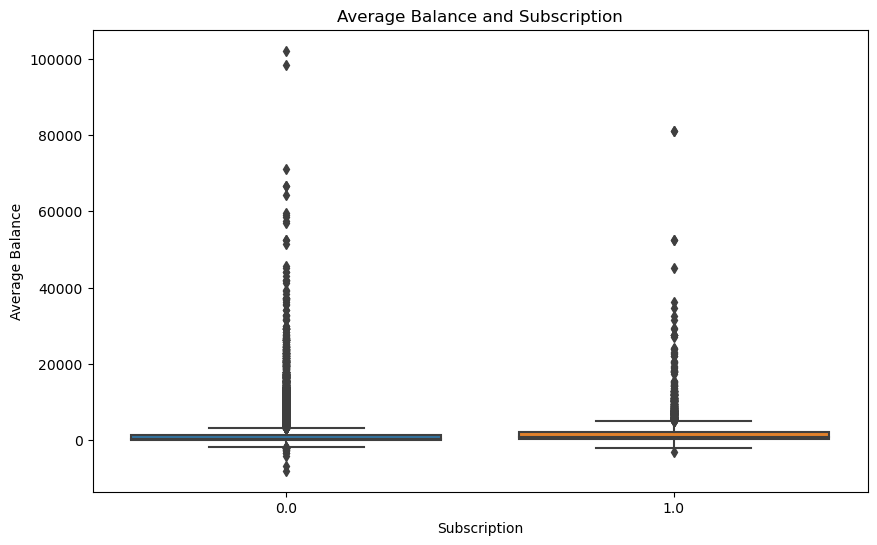

Mean balance for subscribed clients: 1804.2679145396105
Mean balance for not subscribed clients: 1303.7149691899203
T-test p-value for balance: 2.5211136918751468e-29


In [27]:
# Hypothesis 1
plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='balance', data=df)
plt.title('Average Balance and Subscription')
plt.xlabel('Subscription')
plt.ylabel('Average Balance')
plt.show()

balance_subscribed = df[df['y'] == 1]['balance'].mean()
balance_not_subscribed = df[df['y'] == 0]['balance'].mean()

print("Mean balance for subscribed clients:", balance_subscribed)
print("Mean balance for not subscribed clients:", balance_not_subscribed)

t_stat, p_value = stats.ttest_ind(df[df['y'] == 1]['balance'], df[df['y'] == 0]['balance'])
print("T-test p-value for balance:", p_value)


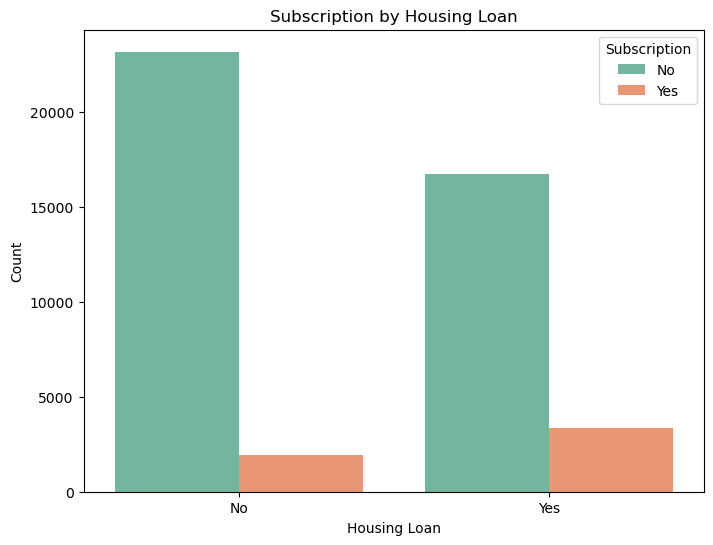

In [28]:
# Hypothesis 2
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='housing', hue='y', palette='Set2')
plt.title('Subscription by Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.legend(title='Subscription', loc='upper right', labels=['No', 'Yes'])
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()


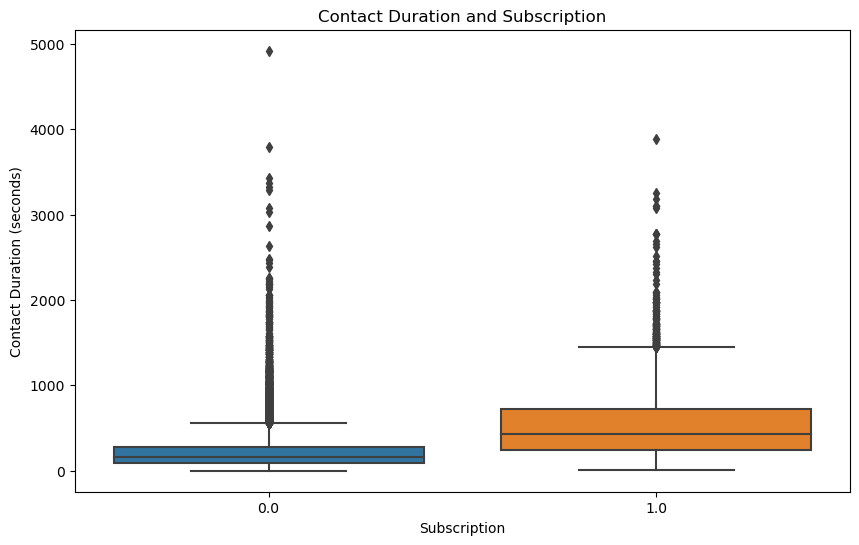

Correlation between contact duration and subscription: 0.39452101589456184


In [29]:
# Hypothesis 3
plt.figure(figsize=(10, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Contact Duration and Subscription')
plt.xlabel('Subscription')
plt.ylabel('Contact Duration (seconds)')
plt.show()

# Calculate correlation between contact duration and subscription
correlation = df['duration'].corr(df['y'])
print("Correlation between contact duration and subscription:", correlation)

In [30]:
# Train-test split
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=42)

# Vector Assembler
feature_columns = [col for col in spark_df.columns if col != 'y']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Model selection 
lr = LogisticRegression(labelCol="y", featuresCol="features")
rf = RandomForestClassifier(labelCol="y", featuresCol="features")
gbt = GBTClassifier(labelCol="y", featuresCol="features")

# Hyperparameter tuning using GridSearchCV
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .build()

param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

# Evaluation metrics
evaluator = BinaryClassificationEvaluator(labelCol="y", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Cross-validation
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5)
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=5)

# Fit models
cv_model_lr = cv_lr.fit(train_data)
cv_model_rf = cv_rf.fit(train_data)
cv_model_gbt = cv_gbt.fit(train_data)

# Best models
best_model_lr = cv_model_lr.bestModel
best_model_rf = cv_model_rf.bestModel
best_model_gbt = cv_model_gbt.bestModel

# Evaluation on test data
predictions_lr = best_model_lr.transform(test_data)
predictions_rf = best_model_rf.transform(test_data)
predictions_gbt = best_model_gbt.transform(test_data)

# Evaluation metrics
accuracy_lr = evaluator.evaluate(predictions_lr)
accuracy_rf = evaluator.evaluate(predictions_rf)
accuracy_gbt = evaluator.evaluate(predictions_gbt)

print("Accuracy for Logistic Regression (Hypothesis 1):", accuracy_lr)
print("Accuracy for Random Forest (Hypothesis 1):", accuracy_rf)
print("Accuracy for Gradient Boosting (Hypothesis 1):", accuracy_gbt)


24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1015.0 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1032.1 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1061.5 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1108.6 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1105.5 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1106.0 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1107.7 KiB
24/05/09 22:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1110.0 KiB
24/05/09 22:49:33 WAR

Accuracy for Logistic Regression (Hypothesis 1): 0.8876615191854568
Accuracy for Random Forest (Hypothesis 1): 0.8956359314248444
Accuracy for Gradient Boosting (Hypothesis 1): 0.920527492119478


In [31]:
# Hypothesis 2
train_data_hypo2 = train_data.filter(train_data['housing'] == 1.11867408194187)
test_data_hypo2 = test_data.filter(test_data['housing'] == 1.11867408194187)

cv_model_lr_hypo2 = cv_lr.fit(train_data_hypo2)
cv_model_rf_hypo2 = cv_rf.fit(train_data_hypo2)
cv_model_gbt_hypo2 = cv_gbt.fit(train_data_hypo2)

# Making predictions
predictions_lr_hypo2 = cv_model_lr_hypo2.transform(test_data_hypo2)
predictions_rf_hypo2 = cv_model_rf_hypo2.transform(test_data_hypo2)
predictions_gbt_hypo2 = cv_model_gbt_hypo2.transform(test_data_hypo2)

# Evaluation metrics for Hypothesis 2
accuracy_lr_hypo2 = evaluator.evaluate(predictions_lr_hypo2)
accuracy_rf_hypo2 = evaluator.evaluate(predictions_rf_hypo2)
accuracy_gbt_hypo2 = evaluator.evaluate(predictions_gbt_hypo2)

print("\nAccuracy for Logistic Regression (Hypothesis 2):", accuracy_lr_hypo2)
print("Accuracy for Random Forest (Hypothesis 2):", accuracy_rf_hypo2)
print("Accuracy for Gradient Boosting (Hypothesis 2):", accuracy_gbt_hypo2)


24/05/09 22:52:01 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
24/05/09 22:52:01 WARN DAGScheduler: Broadcasting large task binary with size 1000.5 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1009.5 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1018.6 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1035.6 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1064.3 KiB
24/05/09 22:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1108.3 KiB
24/05/09 22:52:02 WAR


Accuracy for Logistic Regression (Hypothesis 2): 0.8720576977265785
Accuracy for Random Forest (Hypothesis 2): 0.8930585265339293
Accuracy for Gradient Boosting (Hypothesis 2): 0.9082159430779496


In [32]:
# Hypothesis 3
train_data_hypo3 = train_data.filter(train_data['duration'] > 0)
test_data_hypo3 = test_data.filter(test_data['duration'] > 0)

cv_model_lr_hypo3 = cv_lr.fit(train_data_hypo3)
cv_model_rf_hypo3 = cv_rf.fit(train_data_hypo3)
cv_model_gbt_hypo3 = cv_gbt.fit(train_data_hypo3)

predictions_lr_hypo3 = cv_model_lr_hypo3.transform(test_data_hypo3)
predictions_rf_hypo3 = cv_model_rf_hypo3.transform(test_data_hypo3)
predictions_gbt_hypo3 = cv_model_gbt_hypo3.transform(test_data_hypo3)

accuracy_lr_hypo3 = evaluator.evaluate(predictions_lr_hypo3)
accuracy_rf_hypo3 = evaluator.evaluate(predictions_rf_hypo3)
accuracy_gbt_hypo3 = evaluator.evaluate(predictions_gbt_hypo3)

print("\nAccuracy for Logistic Regression (Hypothesis 3):", accuracy_lr_hypo3)
print("Accuracy for Random Forest (Hypothesis 3):", accuracy_rf_hypo3)
print("Accuracy for Gradient Boosting (Hypothesis 3):", accuracy_gbt_hypo3)


spark.stop()

24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1022.2 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1022.6 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1023.3 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1026.6 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1030.9 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1038.7 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1053.4 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1076.6 KiB
24/05/09 22:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.2 KiB
24/05/09 22:54:27 WAR


Accuracy for Logistic Regression (Hypothesis 3): 0.8038443992744068
Accuracy for Random Forest (Hypothesis 3): 0.8288863018450058
Accuracy for Gradient Boosting (Hypothesis 3): 0.8469189492257182


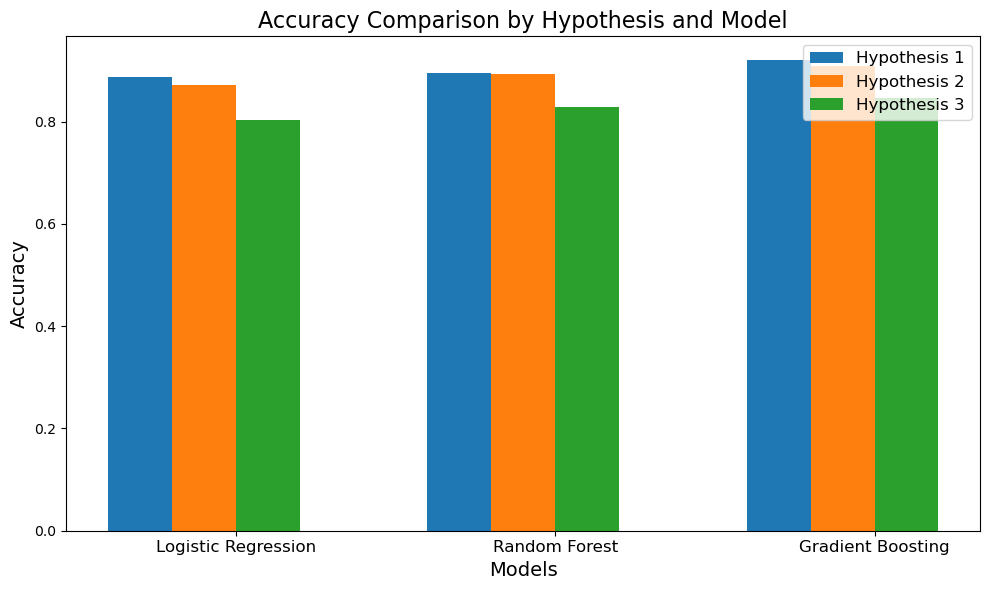

In [33]:
# Accuracy results
hypotheses = ['Hypothesis 1', 'Hypothesis 2', 'Hypothesis 3']
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [
    [accuracy_lr, accuracy_rf, accuracy_gbt],
    [accuracy_lr_hypo2, accuracy_rf_hypo2, accuracy_gbt_hypo2],
    [accuracy_lr_hypo3, accuracy_rf_hypo3, accuracy_gbt_hypo3]
]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = range(len(models))

for i, (hypothesis, accuracy) in enumerate(zip(hypotheses, accuracies)):
    ax.bar([x + i * bar_width for x in index], accuracy, bar_width, label=hypothesis)

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_title('Accuracy Comparison by Hypothesis and Model', fontsize=16)
ax.set_xticks([x + 1.5 * bar_width for x in index])
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()
